## Dimension reduction & Visualization

이번 실습자료는 "Introduction to Machine Learning with Python", Andreas C.Muller&Sarah Guido 책의 'Unsupervised Learning and Preprocessing' chapter를 참조하였습니다.

### PCA(Principal Component Analysis)

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
cancer = load_breast_cancer()
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [3]:
from sklearn.decomposition import PCA

In [4]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

n_components는 우리가 유지하고 싶은 components의 수를 뜻한다.

In [5]:
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


fit 메소드를 이용하여 principal component를 찾는다.

transform 메소드를 이용하여 rotation, dimension reducion을 적용한다.

In [6]:
import matplotlib.pyplot as plt

In [7]:
X_pca_mal = X_pca[cancer.target==0,:]
X_pca_ben = X_pca[cancer.target==1,:]

Text(0,0.5,'Second principal component')

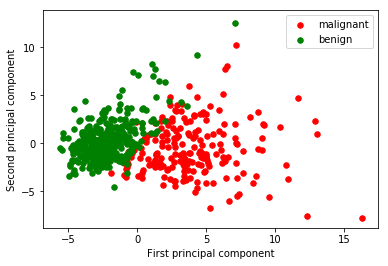

In [8]:
plt.figure(figsize=(8,8))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(X_pca_mal[:,0], X_pca_mal[:,1], c="red", s=30, label="malignant")
ax.scatter(X_pca_ben[:,0], X_pca_ben[:,1], c="green", s=30, label="benign")
plt.legend(cancer.target_names, loc="best")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

위 그림을 통해 PCA는 unsupervised method임에도 두 클래스의 특징을 비교적 잘 추출했다고 볼 수 있다. 

또한 위 그림을 통해 malignant와 benign이 linear classifier로 분리 될 수 있음을 추측해볼 수 있다.

위의 PCA의 두 축은 원래 breast_cancer featrue의 조합으로 이루어져있다.
(principal component들은 원래 데이터에서의 eigenvector)

따라서 principal component들을 해석하는 것은 어려움이 있다.

### Eigenfaces for feature extraction

Feature extraction은 분석에 용이한 데이터를 추출하는 작업이다.

여러 dimension reduction 방법을 이용하여 이미지의 feature extraction을 수행해보자.

In [9]:
from sklearn.datasets import fetch_lfw_people

In [10]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

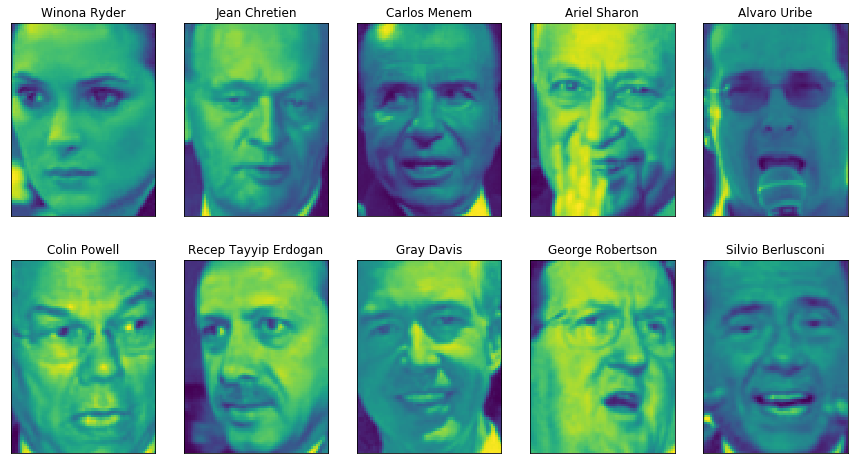

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks':(), 'yticks':()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [12]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [13]:
counts = np.bincount(people.target)
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='\t')
    if(i + 1) % 3 == 0:
        print()

Alejandro Toledo           39	Alvaro Uribe               35	Amelie Mauresmo            21	
Andre Agassi               36	Angelina Jolie             20	Ariel Sharon               77	
Arnold Schwarzenegger      42	Atal Bihari Vajpayee       24	Bill Clinton               29	
Carlos Menem               21	Colin Powell              236	David Beckham              31	
Donald Rumsfeld           121	George Robertson           22	George W Bush             530	
Gerhard Schroeder         109	Gloria Macapagal Arroyo    44	Gray Davis                 26	
Guillermo Coria            30	Hamid Karzai               22	Hans Blix                  39	
Hugo Chavez                71	Igor Ivanov                20	Jack Straw                 28	
Jacques Chirac             52	Jean Chretien              55	Jennifer Aniston           21	
Jennifer Capriati          42	Jennifer Lopez             21	Jeremy Greenstock          24	
Jiang Zemin                20	John Ashcroft              53	John Negroponte            31	

위 정보를 통해 데이터가 skewed 되어있음을 확인할 수 있다.

데이터의 편향을 줄이기 위해 각 사람마다 50장의 사진을 추린다.

In [14]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

#scale the grayscale values to be between 0 and 1
#instead of 0 and 255 for better numeric stability
X_people = X_people/255.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

In [17]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


62개의 class(사람)를 random으로 classification했을 때의 정확도는 1/62=1.6%이다.

이와 비교하면 1-nn의 정확도는 매우 나쁜 것은 아니다.

하지만 객관적으로 볼 때 좋은 성능은 아니며 pixel representation data를 distance measure를 이용해 similarity를 계산하는 것은 좋은 선택은 아니다.

In [18]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


In [20]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


PCA로 줄인 dimension을 복원하여 이미지로 나타내보자

In [21]:
X_pca_inv = pca.inverse_transform(X_train_pca)
X_pca_recon = np.reshape(X_pca_inv,(1547,87,65))

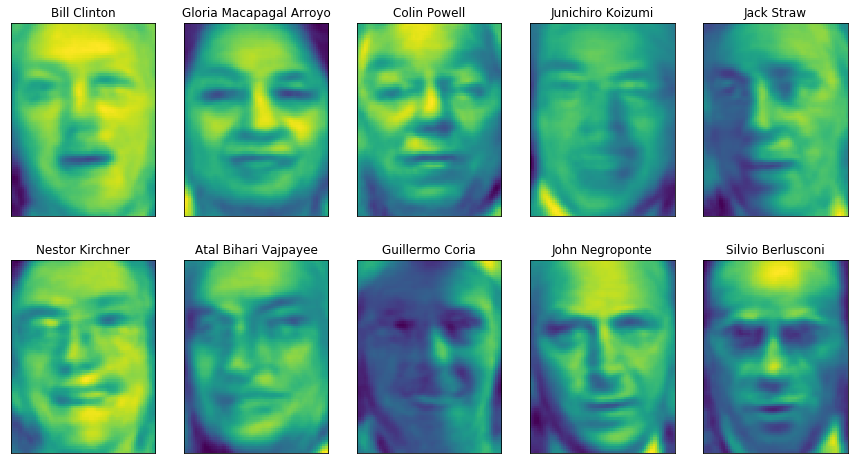

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks':(), 'yticks':()})
for target, image, ax in zip(y_train, X_pca_recon, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [23]:
import mglearn

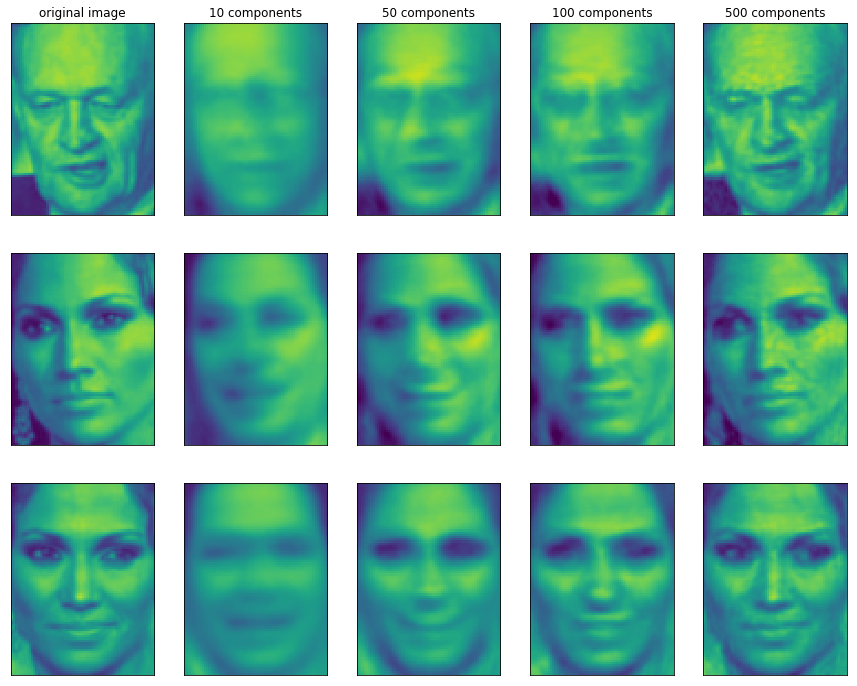

In [24]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

### NMF(Non-Negative Matrix Factorization)

In [25]:
from sklearn.decomposition import NMF

In [26]:
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

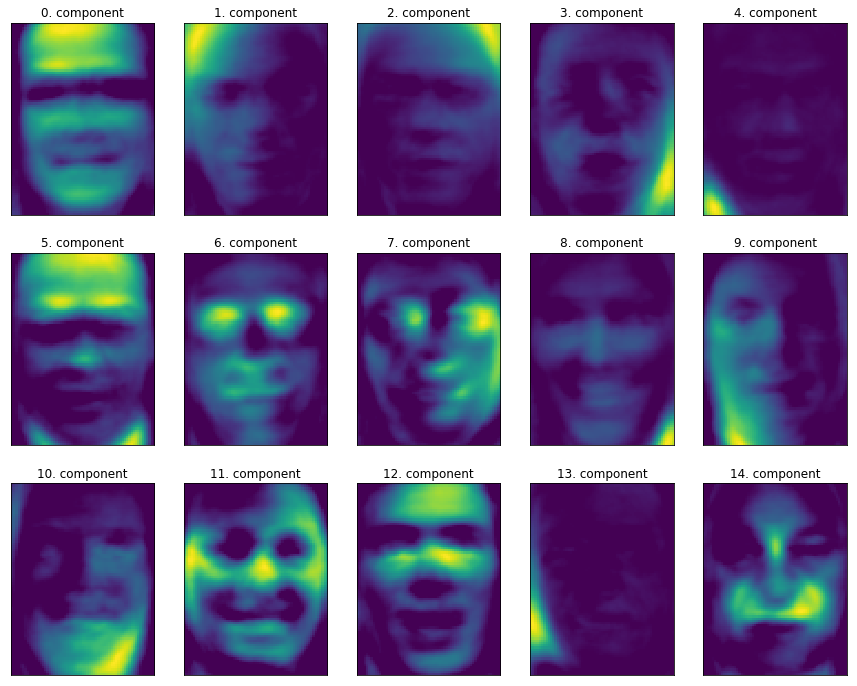

In [27]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

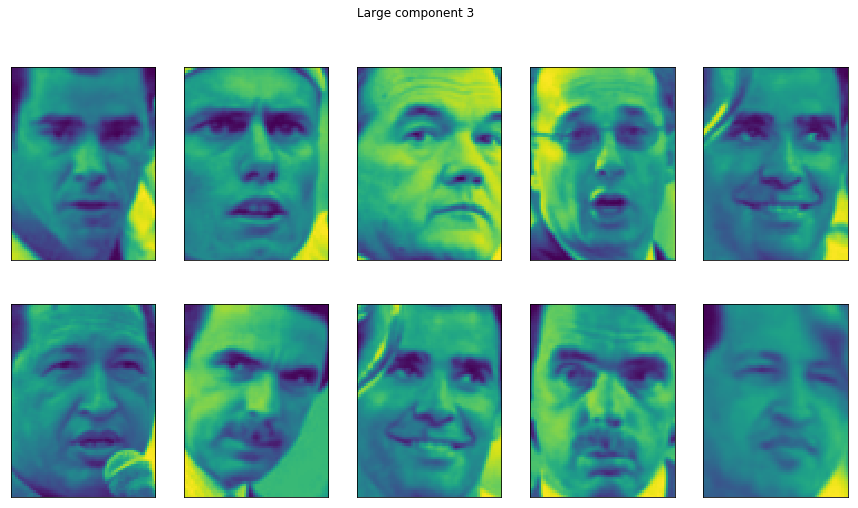

In [28]:
compn = 3
inds = np.argsort(X_train_nmf[:,compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks':(), 'yticks':()})
fig.suptitle("Large component 3")
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

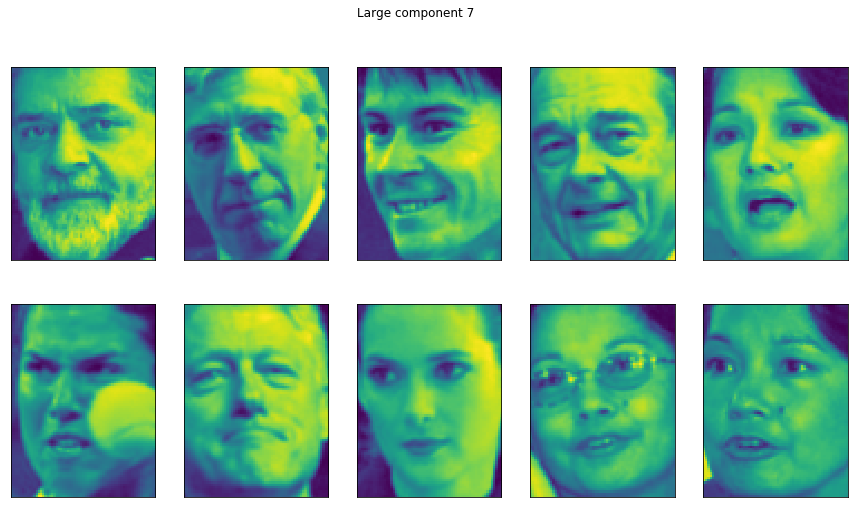

In [29]:
compn = 7
inds = np.argsort(X_train_nmf[:,compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks':(), 'yticks':()})
fig.suptitle("Large component 7")
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

### t-SNE(t distributed-Stochastic Neighbor Embedding)

In [30]:
from sklearn.datasets import load_digits

In [31]:
digits = load_digits()

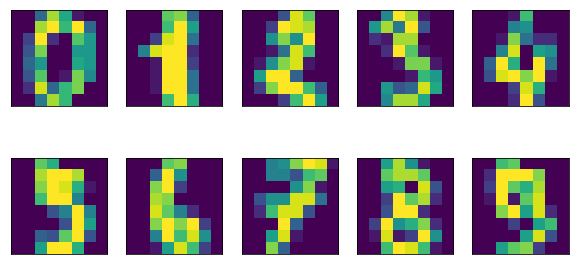

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':(), 'yticks':()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

Text(0,0.5,'Second principal component')

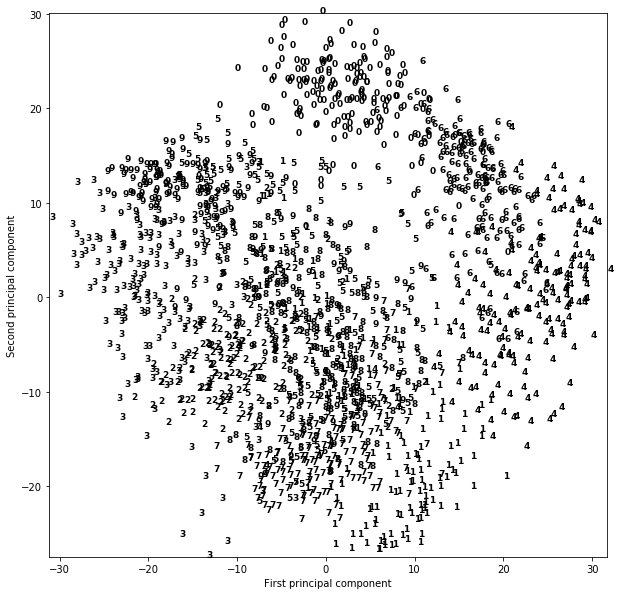

In [33]:
pca = PCA(n_components=2)
pca.fit(digits.data)
digits_pca = pca.transform(digits.data)
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:,0].min(), digits_pca[:,0].max())
plt.ylim(digits_pca[:,1].min(), digits_pca[:,1].max())
for i in range(len(digits.data)):
    plt.text(digits_pca[i,0], digits_pca[i,1], str(digits.target[i]),fontdict={'weight':'bold', 'size':9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

In [34]:
from sklearn.manifold import TSNE

In [35]:
tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)

Text(0,0.5,'t-SNE feature 1')

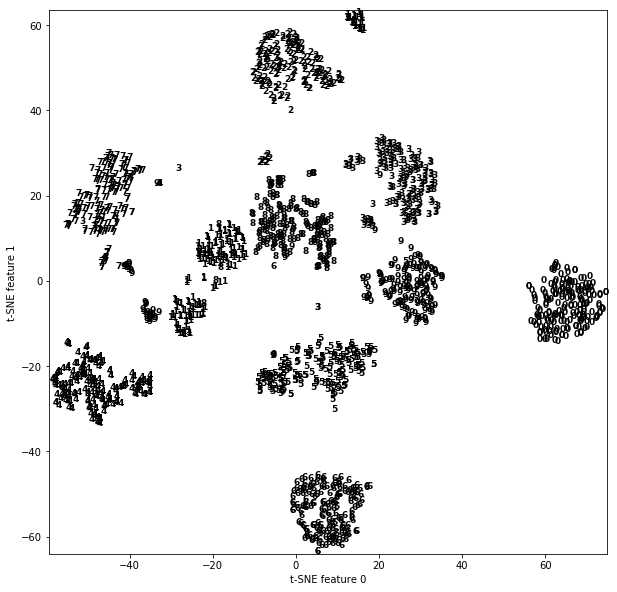

In [36]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:,0].min(), digits_tsne[:,0].max()+1)
plt.ylim(digits_tsne[:,1].min(), digits_tsne[:,1].max()+1)
for i in range(len(digits.data)):
    plt.text(digits_tsne[i,0], digits_tsne[i,1], str(digits.target[i]),fontdict={'weight':'bold', 'size':9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

### Autoencoder

참조 : http://deeplearning.net/tutorial/dA.html#running-the-code

# Clustering

### K-Means Clustering

In [37]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score

In [38]:
X, y = make_blobs(random_state=1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [39]:
print("Cluster members:\n{}".format(kmeans.labels_))

Cluster members:
[0 1 1 1 2 2 2 1 0 0 1 1 2 0 2 2 2 0 1 1 2 1 2 0 1 2 2 0 0 2 0 0 2 0 1 2 1
 1 1 2 2 1 0 1 1 2 0 0 0 0 1 2 2 2 0 2 1 1 0 0 1 2 2 1 1 2 0 2 0 1 1 1 2 0
 0 1 2 2 0 1 0 1 1 2 0 0 0 0 1 0 2 0 0 1 1 2 2 0 2 0]


In [40]:
print(kmeans.predict(X))

[0 1 1 1 2 2 2 1 0 0 1 1 2 0 2 2 2 0 1 1 2 1 2 0 1 2 2 0 0 2 0 0 2 0 1 2 1
 1 1 2 2 1 0 1 1 2 0 0 0 0 1 2 2 2 0 2 1 1 0 0 1 2 2 1 1 2 0 2 0 1 1 1 2 0
 0 1 2 2 0 1 0 1 1 2 0 0 0 0 1 0 2 0 0 1 1 2 2 0 2 0]


Text(0,0.5,'Feature 1')

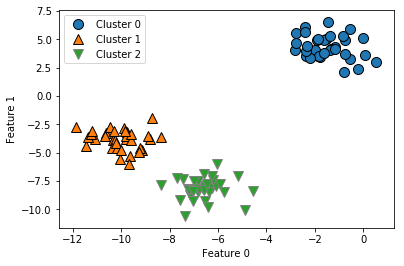

In [41]:
mglearn.discrete_scatter(X[:,0], X[:,1], kmeans.predict(X))
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [42]:
X, y = make_blobs(random_state=1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [43]:
adjusted_rand_score(y, kmeans.predict(X))

1.0

In [44]:
silhouette_score(X, kmeans.fit_predict(X))

0.7697092791808455

ARI(Adjusted Random Index)는 ground truth값이 필요

silhouette은 ground truth값이 필요없음

In [45]:
from sklearn.datasets import make_moons

In [46]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)

Text(0,0.5,'Feature 1')

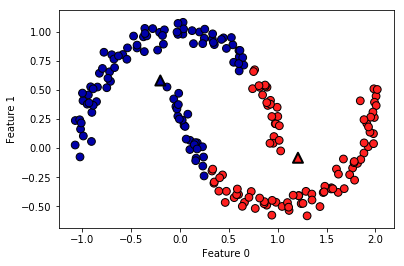

In [47]:
plt.scatter(X[:,0], X[:,1], c=y_pred, cmap=mglearn.cm2, s=60, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='^', c=[mglearn.cm2(0), mglearn.cm2(1)], s=100, linewidth=2, edgecolor='k')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [48]:
adjusted_rand_score(y, y_pred)

0.25636350688711773

In [49]:
silhouette_score(X, kmeans.fit_predict(X))

0.49215648268306905

### Agglomerative Clustering

In [50]:
from sklearn.cluster import AgglomerativeClustering

In [51]:
X, y = make_blobs(random_state=1)
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

Text(0,0.5,'Feature 1')

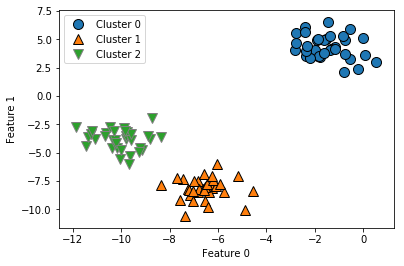

In [52]:
mglearn.discrete_scatter(X[:,0], X[:,1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [53]:
adjusted_rand_score(y, assignment)

1.0

In [54]:
silhouette_score(X, assignment)

0.7697092791808455

In [55]:
from scipy.cluster.hierarchy import dendrogram, ward

In [56]:
X, y = make_blobs(random_state=0, n_samples=12)
linkage_array = ward(X)

Text(0,0.5,'Cluster distance')

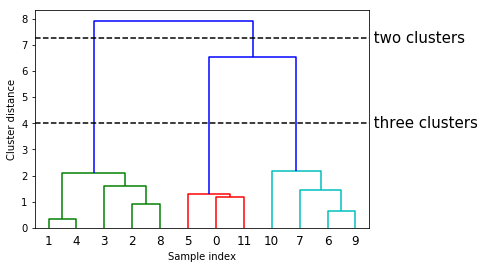

In [57]:
dendrogram(linkage_array)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4,4], '--', c='k')
ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size':15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size':15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

In [58]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

Text(0,0.5,'Feature 1')

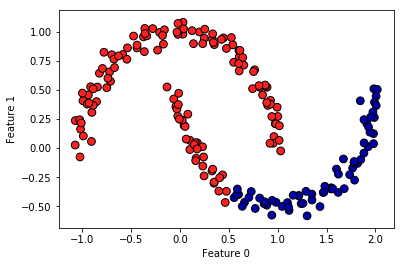

In [59]:
plt.scatter(X[:,0], X[:,1], c=assignment, cmap=mglearn.cm2, s=60, edgecolor='k')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [60]:
adjusted_rand_score(y, assignment)

0.39023417956211537

In [61]:
silhouette_score(X, assignment)

0.4016534751569457

### DBSCAN(Density-Based Spatial Clustering of Applications with Noise)

DBSCAN은 데이터의 밀집도를 고려하여 복잡한 모양의 cluster를 알아낼 수 있다.

In [62]:
from sklearn.cluster import DBSCAN

In [63]:
X, y = make_blobs(random_state=0)
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)

Text(0,0.5,'Feature 1')

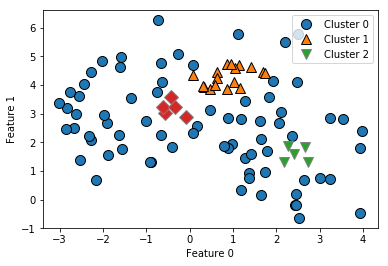

In [64]:
mglearn.discrete_scatter(X[:,0], X[:,1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [65]:
adjusted_rand_score(y,clusters)

0.0732421421157808

In [66]:
silhouette_score(X, clusters)

-0.19510501476337017

In [67]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
dbscan = DBSCAN()
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

clusters = dbscan.fit_predict(X_scaled)

Text(0,0.5,'Feature 1')

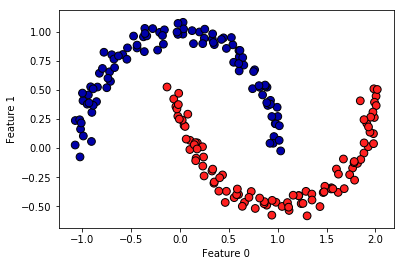

In [68]:
plt.scatter(X[:,0], X[:,1], c=clusters, cmap=mglearn.cm2, s=60, edgecolor='k')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [69]:
adjusted_rand_score(y,clusters)

1.0

In [70]:
silhouette_score(X_scaled, clusters)

0.382386022679393